## Build Back Testing
Follow the buy and sell decisions from both the retail investors or the institution investors as per fund flow data provided, build two trading strategies Smart Retail Flow FT5009 and Smart Insti Flow FT5009. That is, you buy and sell the same stocks as retail investors or institutional investors from the fund flow report.

The strategy Smart Retail Flow FT5009 strictly follows the weekly buy sell decisions of retail investors and the strategy Smart Insti Flow FT5009 strictly follows the weekly buy sell decisions of institution investors.

close or open 

In [2]:
import pandas as pd
import numpy as np

top_stocks_path = './data/flow_info.csv'
stock_prices_path = './data/stock_info.csv'
# Read simulated fund flow data
top_stocks_data = pd.read_csv(top_stocks_path)
stock_prices_data = pd.read_csv(stock_prices_path)
PRICE = 'Open'

# Initialize parameters
initial_capital = 1_000_000  # Initial capital 1M
min_trade_units = 100        # Minimum trade units 100 shares
holding_period_limit = 4     # Maximum holding period 4 weeks
borrow_cost_rate = 0.001     # Borrow cost rate 0.1%
weekly_capital_interval = 4  # Recalculate trading capital every 4 weeks
borrow_cash = 100_000        # Borrow cash 100k each time

# Create two strategy portfolios
portfolio_retail = {}
portfolio_institution = {}

# Set trading dates and stock codes
dates = top_stocks_data['Date'].unique()

# Initialize portfolios
portfolio_retail[dates[0]] = {
    'cash': initial_capital,
    'short_sell_cash': 0, # Short sell cash is locked, i.e., weekly trading capital is 1/4 of cash, excluding short sell cash
    'position_units': {},
    'holding_weeks': {},
    'net_value': 0,
    'borrow_cash': 0,
}
portfolio_institution[dates[0]] = {
    'cash': initial_capital,
    'short_sell_cash': 0,
    'position_units': {},
    'holding_weeks': {},
    'net_value': 0,
    'borrow_cash': 0,
}

# Execute trading decisions weekly
for i, date in enumerate(dates):
    print(f"Week {i+1}: {date}")

    # Get retail and institutional trading signals
    retail_signals = top_stocks_data[(top_stocks_data['Date'] == date) & (top_stocks_data['Investor Type'] == 'retail')]
    insti_signals = top_stocks_data[(top_stocks_data['Date'] == date) & (top_stocks_data['Investor Type'] == 'institution')]

    # Process trading signals for each strategy
    for strategy, signals, portfolio in zip(
            ['Smart Retail Flow FT5009', 'Smart Insti Flow FT5009'],
            [retail_signals, insti_signals],
            [portfolio_retail, portfolio_institution]):
        
        # Filter out stock codes that do not exist in stock_prices_data
        signals = signals[signals['Stock Code'].isin(stock_prices_data['Stock Code'])]

        # Get current portfolio for the date
        if i > 0:
            # Copy the portfolio state from the previous week
            portfolio[date] = portfolio[dates[i-1]].copy()
        
        current_portfolio = portfolio[date]
        
        current_portfolio['net_value'] = 0  # Reset net value

        # Buy back shorted stocks and calculate borrow cost (this step may cause short_sell_cash < 0 because the position is forced to be zero in one week, and the stock price may be higher than when short sold, causing a loss when buying back at a higher price, plus the borrow cost)
        for stock_code, units in list(current_portfolio['position_units'].items()):
            if units < 0:  # Only calculate borrow cost for short positions
                if stock_prices_data[(stock_prices_data['Date'] == dates[i - 1]) & (stock_prices_data['Stock Code'] == stock_code)].shape[0] > 0:  # Ensure there is data for the previous week
                    prev_date = dates[i - 1]
                    prev_price = stock_prices_data[(stock_prices_data['Date'] == prev_date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
                else:
                    prev_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
                cur_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
                avg_price = (prev_price + cur_price) / 2
                borrow_cost = abs(units) * avg_price * borrow_cost_rate
                current_portfolio['cash'] -= borrow_cost
                current_portfolio['short_sell_cash'] -= abs(units) * cur_price
                del current_portfolio['position_units'][stock_code]  # Clear short position

        # If short sell results in a loss, cover the loss with cash
        if current_portfolio['short_sell_cash'] < 0:
            current_portfolio['cash'] += current_portfolio['short_sell_cash']
            current_portfolio['short_sell_cash'] = 0

        # If cash is insufficient, borrow cash (ignoring borrow interest for now)
        if current_portfolio['cash'] < 0:
            while current_portfolio['cash'] < 0:
                current_portfolio['cash'] += borrow_cash
                current_portfolio['borrow_cash'] += borrow_cash

        # Recalculate weekly trading capital every 4 weeks
        if i % weekly_capital_interval == 0:
            weekly_capital = current_portfolio['cash'] / weekly_capital_interval

        # When cash is insufficient, sell the smallest position until there is enough cash (> weekly_capital) to ensure sufficient weekly trading capital
        while current_portfolio['cash'] < weekly_capital:
            # If there are no positions, break
            if len(current_portfolio['position_units']) == 0:
                break
            # Sell the smallest position
            stock_code = min(current_portfolio['position_units'], key=current_portfolio['position_units'].get)
            units = current_portfolio['position_units'][stock_code]
            try:
                stock_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
            except:
                print(date, stock_code)
                ii = i
                tmp_date = dates[ii]
                while stock_prices_data[(stock_prices_data['Date'] == tmp_date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].shape[0] == 0:
                    ii -= 1
                    tmp_date = dates[ii]
                stock_price = stock_prices_data[(stock_prices_data['Date'] == tmp_date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]                    
            
            sell_units = min(min_trade_units, abs(units))
            current_portfolio['cash'] += sell_units * stock_price
            current_portfolio['position_units'][stock_code] -= sell_units
            if current_portfolio['position_units'][stock_code] == 0:
                del current_portfolio['position_units'][stock_code]
                del current_portfolio['holding_weeks'][stock_code]
            else:
                # No need to update holding weeks, as this is just to cover cash shortfall
                pass

        # Calculate buy and sell signal strengths
        buy_signals = signals[signals['Action'] == 'buy']
        sell_signals = signals[signals['Action'] == 'sell']
        buy_signal_strength = buy_signals['Amount'].abs().sum()
        sell_signal_strength = sell_signals['Amount'].abs().sum()

        # Process buy signals
        for _, signal in buy_signals.iterrows():
            stock_code = signal['Stock Code']
            amount = abs(signal['Amount'])
            signal_strength = amount / buy_signal_strength  # Buy signal strength

            trade_value = weekly_capital * signal_strength
            # Get stock price
            stock_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
            units = int(trade_value / stock_price / min_trade_units) * min_trade_units

            # Increase position and record holding weeks
            if units > 0:
                total_cost = units * stock_price
                current_portfolio['cash'] -= total_cost
                current_portfolio['position_units'][stock_code] = current_portfolio['position_units'].get(stock_code, 0) + units
                current_portfolio['holding_weeks'][stock_code] = 1  # Reset holding weeks
            # print('Bought', units, 'units of', stock_code, current_portfolio)

        # Process sell signals
        for _, signal in sell_signals.iterrows():
            stock_code = signal['Stock Code']
            amount = abs(signal['Amount'])
            signal_strength = amount / sell_signal_strength  # Sell signal strength

            trade_value = weekly_capital * signal_strength
            # Get stock price
            stock_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
            units = int(trade_value / stock_price / min_trade_units) * min_trade_units

            if units > 0:
                # Check if there is a position
                held_units = current_portfolio['position_units'].get(stock_code, 0)
                if held_units > 0:
                    # Sell part of the position
                    sell_units = min(units, held_units)
                    current_portfolio['cash'] += sell_units * stock_price
                    current_portfolio['position_units'][stock_code] -= sell_units
                    if current_portfolio['position_units'][stock_code] == 0:
                        del current_portfolio['position_units'][stock_code]
                        del current_portfolio['holding_weeks'][stock_code]
                    else:
                        current_portfolio['holding_weeks'][stock_code] += 1
                   
                    # Handle the remaining part as short sell
                    if sell_units < units:
                        short_units = units - sell_units
                        current_portfolio['short_sell_cash'] += short_units * stock_price  # Short sell proceeds added to cash
                        current_portfolio['position_units'][stock_code] = current_portfolio['position_units'].get(stock_code, 0) - short_units

                else:
                    # Execute short sell if there is no position
                    current_portfolio['short_sell_cash'] += units * stock_price
                    current_portfolio['position_units'][stock_code] = current_portfolio['position_units'].get(stock_code, 0) - units
            # print('Sold', units, 'units of', stock_code, current_portfolio)

        # Update holding weeks
        for stock_code in current_portfolio['position_units']:
            if stock_code not in buy_signals['Stock Code'].values and stock_code not in sell_signals['Stock Code'].values:
                current_portfolio['holding_weeks'][stock_code] += 1

        # Clear positions exceeding holding period limit
        for stock_code, weeks in list(current_portfolio['holding_weeks'].items()):
            if weeks >= holding_period_limit:
                # Force sell remaining position
                units = current_portfolio['position_units'][stock_code]
                stock_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
                current_portfolio['cash'] += units * stock_price  # Sell position

                del current_portfolio['position_units'][stock_code]
                del current_portfolio['holding_weeks'][stock_code]

        # Assume all stocks are converted to cash, net value calculation
        for stock_code, units in list(current_portfolio['position_units'].items()):
            stock_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
            if units < 0:
                # Ensure there is data for the previous week
                if stock_prices_data[(stock_prices_data['Date'] == dates[i - 1]) & (stock_prices_data['Stock Code'] == stock_code)].shape[0] > 0:
                    prev_date = dates[i - 1]
                    prev_price = stock_prices_data[(stock_prices_data['Date'] == prev_date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
                else:
                    prev_price = stock_prices_data[(stock_prices_data['Date'] == date) & (stock_prices_data['Stock Code'] == stock_code)][PRICE].values[0]
                avg_price = (prev_price + stock_price) / 2
                current_portfolio['net_value'] += units * avg_price * borrow_cost_rate

            current_portfolio['net_value'] += units * stock_price

        current_portfolio['net_value'] += (current_portfolio['cash'] + current_portfolio['short_sell_cash'] - current_portfolio['borrow_cash'])
        
        print(f"{strategy} Portfolio cash: {current_portfolio['cash']:.2f}, short_sell_cash: {current_portfolio['short_sell_cash']:.2f}, borrow_cash: {current_portfolio['borrow_cash']:.2f}, net_value: {current_portfolio['net_value']:.2f}")
        
        # Format output for positive and negative positions
        positive_positions = {k: v for k, v in current_portfolio['position_units'].items() if v > 0}
        negative_positions = {k: v for k, v in current_portfolio['position_units'].items() if v < 0}

        positive_df = pd.DataFrame(list(positive_positions.items()), columns=['Stock Code', 'Positive Units'])
        negative_df = pd.DataFrame(list(negative_positions.items()), columns=['Stock Code', 'Negative Units'])

        # Merge two DataFrames
        merged_df = pd.merge(positive_df, negative_df, on='Stock Code', how='outer')

        # Fill NaN values with 0
        merged_df = merged_df.fillna(0)

        # Format output
        print("Combined Positions:")
        print(merged_df.to_string(index=False))
        print()
       
print("Retail Portfolio Final:", portfolio_retail[dates[-1]])
print("Institution Portfolio Final:", portfolio_institution[dates[-1]])

Week 1: 2019-01-07
Smart Retail Flow FT5009 Portfolio cash: 750604.09, short_sell_cash: 245325.12, borrow_cash: 0.00, net_value: 998362.18
Combined Positions:
Stock Code  Positive Units  Negative Units
       544         27600.0             0.0
       5CP         56800.0             0.0
       BDX        449900.0             0.0
       BN4             0.0         -5100.0
       C09             0.0         -2400.0
      C38U         12600.0             0.0
       CC3         11300.0             0.0
      CJLU         22900.0             0.0
       D05             0.0         -3400.0
       G13             0.0        -15400.0
       H02          1200.0             0.0
       O39             0.0         -6900.0
       U11             0.0         -1900.0
       V03             0.0         -1400.0
       Y92             0.0      -4825600.0
       Z74             0.0         -7800.0

Smart Insti Flow FT5009 Portfolio cash: 752916.25, short_sell_cash: 249125.05, borrow_cash: 0.00, net_value: 

C:\Users\gzh\AppData\Local\Temp\ipykernel_4660\1711584567.py:237: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


Smart Insti Flow FT5009 Portfolio cash: 1028775.88, short_sell_cash: 546778.40, borrow_cash: 0.00, net_value: 2839772.50
Combined Positions:
Stock Code  Positive Units  Negative Units
      A17U         75000.0             0.0
      A7RU         27100.0             0.0
       AGS          9300.0             0.0
      AJBU          9100.0             0.0
       AWX          6100.0             0.0
       BN4         10800.0             0.0
       BS6          5300.0             0.0
       BSL         15000.0             0.0
      BUOU         42200.0             0.0
       C09          5300.0             0.0
      C38U         16300.0             0.0
       C52             0.0         -6400.0
       C6L         33600.0             0.0
      CJLU             0.0        -36700.0
       D05          7200.0             0.0
       F34          6000.0             0.0
       G13         95300.0             0.0
       HMN             0.0         -9800.0
       J36          2500.0             0.0

C:\Users\gzh\AppData\Local\Temp\ipykernel_4660\1711584567.py:237: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


Smart Insti Flow FT5009 Portfolio cash: 1587526.76, short_sell_cash: 586117.82, borrow_cash: 0.00, net_value: 3685022.15
Combined Positions:
Stock Code  Positive Units  Negative Units
       1MZ             0.0        -51500.0
       9CI             0.0         -9400.0
      A17U         13400.0             0.0
       AP4         13100.0             0.0
       AWX             0.0         -6600.0
       BN4          7300.0             0.0
       BS6         99100.0             0.0
       BSL             0.0        -11900.0
      BUOU         10800.0             0.0
       C07           900.0             0.0
       C52         23400.0             0.0
       C6L             0.0         -5100.0
       D05         12500.0             0.0
       H78             0.0         -4500.0
      J69U             0.0         -3400.0
      M44U         17600.0             0.0
      N2IU         33600.0             0.0
       O39         36600.0             0.0
       S58          4000.0             0.0

C:\Users\gzh\AppData\Local\Temp\ipykernel_4660\1711584567.py:237: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df = merged_df.fillna(0)


Smart Insti Flow FT5009 Portfolio cash: 679607.23, short_sell_cash: 658512.64, borrow_cash: 0.00, net_value: 4418971.37
Combined Positions:
Stock Code  Positive Units  Negative Units
       5E2         58600.0             0.0
       9CI          5800.0             0.0
      A17U             0.0        -19800.0
       BN4          3100.0             0.0
      BUOU             0.0        -20400.0
      C38U             0.0         -9400.0
       C52          1900.0             0.0
       C6L          2200.0             0.0
       D05         12700.0             0.0
       F34             0.0         -3700.0
       G13         24900.0             0.0
       H78             0.0         -1900.0
      J69U             0.0        -13400.0
      JYEU             0.0        -13000.0
      ME8U             0.0         -5800.0
      N2IU         19900.0             0.0
       O39          9200.0             0.0
       S58         60700.0             0.0
       S63          1200.0             0.0


### Cumulative Returns

In [76]:
retail_net_values = pd.DataFrame([portfolio_retail[date]['net_value'] for date in dates], 
                                 index=pd.to_datetime(dates), 
                                 columns=['net_value'])
retail_net_values = retail_net_values / initial_capital

institution_net_values = pd.DataFrame([portfolio_institution[date]['net_value'] for date in dates], 
                                      index=pd.to_datetime(dates),
                                      columns=['net_value'])
institution_net_values = institution_net_values / initial_capital

cutoff_date = '2023-03-06' # when net value comes to 0
before_cutoff = retail_net_values.loc[:cutoff_date]
after_cutoff = retail_net_values.loc[cutoff_date:]

institution_net_values.head(5)

,net_value
2019-01-07,0.999780
2019-01-14,1.023102
2019-01-21,1.035635
2019-01-28,1.045422
2019-02-04,1.123667


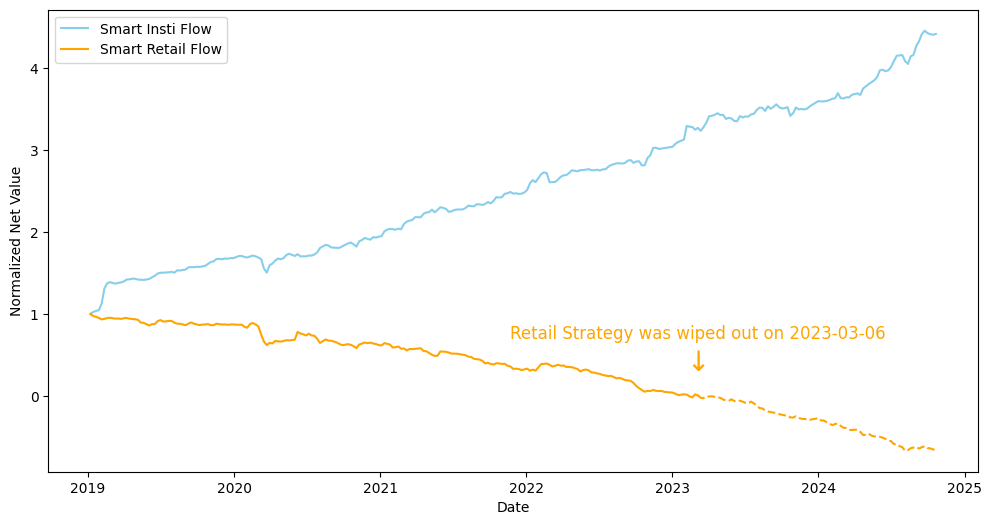

In [77]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(institution_net_values, color='skyblue', linestyle='-', label='Smart Insti Flow')

plt.plot(before_cutoff, color='orange', linestyle='-', label='Smart Retail Flow')
plt.plot(after_cutoff, color='orange', linestyle='--')

plt.text(pd.Timestamp('2023-03-06'), 0.3, "↓", color='orange', fontsize=20, ha='center')
plt.text(pd.Timestamp('2023-03-06'), 0.7, 'Retail Strategy was wiped out on 2023-03-06', color='orange', fontsize=12, ha='center')


plt.xlabel('Date')
plt.ylabel('Normalized Net Value')
plt.legend()
plt.show()


## Evaluation

In [78]:
def calculateStatistics(portfolio_values, risk_free_rate=0.02):
    if portfolio_values.empty:
        return {
            "Annual Return": np.nan,
            "Volatility": np.nan,
            "Sharpe Ratio": np.nan,
            "Sortino Ratio": np.nan,
            "Max Drawdown": np.nan
        }

    returns = portfolio_values.pct_change().dropna()

    annual_return = portfolio_values.iloc[-1] ** (50 / len(portfolio_values)) - 1 # portfolio_values.iloc[0] is 1
    volatility = returns.std() * np.sqrt(50)
    sharpe_ratio = (annual_return - risk_free_rate) / volatility
    sortino_ratio = (annual_return - risk_free_rate) / (returns[returns < 0].std() * np.sqrt(50))
    max_drawdown = ((portfolio_values / portfolio_values.cummax()) - 1).min()
    return {
        "Annual Return": annual_return,
        "Volatility": volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

In [79]:
# Calculate statistics
retail_stats = calculateStatistics(before_cutoff["net_value"])
institution_stats = calculateStatistics(institution_net_values["net_value"])

stats_df = pd.DataFrame([retail_stats, institution_stats], index=['Retail Portfolio', 'Institution Portfolio'])

stats_df = stats_df.transpose()
print(stats_df)

               Retail Portfolio  Institution Portfolio
Annual Return         -0.729426               0.292029
Volatility             1.739790               0.114397
Sharpe Ratio          -0.430757               2.377943
Sortino Ratio         -0.475756               4.030860
Max Drawdown          -1.019773              -0.121745
